In [14]:
# Protein Embedding Project Skeleton
# Requirements: esm, pandas, scikit-learn, matplotlib, umap-learn

import torch
import esm
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
import umap
import numpy as np
import requests


In [ ]:
# === 1. Load lightweight ESM model ===
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()  # Smallest model
batch_converter = alphabet.get_batch_converter()
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data = sequences

In [64]:
# === 2. Define gene list and fetch UniProt FASTA sequences ===
genes = ['AQP4', 'SLC1A2', 'SLC4A4', 'GFAP', 'ALDH1L1', 'GJA1', 'GAD1', 'GAD2',
         'GRIK2', 'KCNC2', 'CDH9', 'KIT', 'SST', 'VIP', 'SV2C', 'SLC17A7', 'SATB2',
         'CAMK2A', 'CBLN2', 'IL1RAPL2', 'TRPM3', 'SEMA3E', 'SYT1', 'RBFOX3',
         'CUX2', 'RORB', 'TLE4', 'TYROBP', 'APBB1IP', 'P2RY12', 'CSF1R', 'CX3CR1',
         'PTPRC', 'DOCK8', 'HLA.DRA', 'OPALIN', 'MOBP', 'MBP', 'PLP1', 'ST18',
         'MOG', 'PDGFRA', 'PCDH15', 'VCAN', 'CSPG4']

species = {
    "human": 9606,
    "chimp": 9598,
    "macaque": 9544
}

base_url = "https://rest.uniprot.org/uniprotkb/stream"
all_embeddings = {sp: {} for sp in species}
MAX_LEN = 512

for sp_name, tax_id in species.items():
    print(f"\nFetching sequences for {sp_name.title()}...")
    for gene in genes:
        query = f"gene:{gene} AND organism_id:{tax_id}"
        params = {
            "query": query,
            "format": "fasta",
            "size": 1
        }
        response = requests.get(base_url, params=params)
        if response.ok and response.text.startswith('>'):
            fasta_io = StringIO(response.text)
            for record in SeqIO.parse(fasta_io, "fasta"):
                seq = str(record.seq)
                if len(seq) > MAX_LEN:
                    seq = seq[:MAX_LEN]
                batch_labels, batch_strs, batch_tokens = batch_converter([(record.id, seq)])
                batch_tokens = batch_tokens.to(device)
                with torch.no_grad():
                    results = model(batch_tokens, repr_layers=[6], return_contacts=False)
                token_representations = results["representations"][6]
                emb = token_representations[0, 1:len(seq)+1].mean(0)
                all_embeddings[sp_name][gene] = emb.cpu().numpy()
        else:
            print(f"{sp_name.title()} - Could not retrieve sequence for {gene}")


Fetching sequences for Human...

Fetching sequences for Chimp...
Chimp - Could not retrieve sequence for P2RY12
Chimp - Could not retrieve sequence for HLA.DRA

Fetching sequences for Macaque...


In [70]:
from sklearn.metrics.pairwise import cosine_distances


In [71]:
# === 3. Compare embeddings across species ===
def cosine_diff(a, b):
    return cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0][0]

diff_table = []
for gene in genes:
    row = {"Gene": gene}
    try:
        row["Human-Chimp"] = cosine_diff(all_embeddings["human"][gene], all_embeddings["chimp"][gene])
    except:
        row["Human-Chimp"] = None
    try:
        row["Human-Macaque"] = cosine_diff(all_embeddings["human"][gene], all_embeddings["macaque"][gene])
    except:
        row["Human-Macaque"] = None
    try:
        row["Chimp-Macaque"] = cosine_diff(all_embeddings["chimp"][gene], all_embeddings["macaque"][gene])
    except:
        row["Chimp-Macaque"] = None
    diff_table.append(row)


In [72]:
# === 4. Display sorted divergence table ===
df_diff = pd.DataFrame(diff_table)
print("\nTop Divergent Genes (Human vs Chimp):")
print(df_diff.sort_values(by="Human-Chimp", ascending=False).head())



Top Divergent Genes (Human vs Chimp):
       Gene  Human-Chimp  Human-Macaque  Chimp-Macaque
15  SLC17A7     0.307917       0.307559       0.000384
10     CDH9     0.285700       0.287909       0.000128
17   CAMK2A     0.255055       0.110113       0.091090
30    CSF1R     0.236122       0.231797       0.006651
42   PCDH15     0.222300       0.070716       0.219231


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


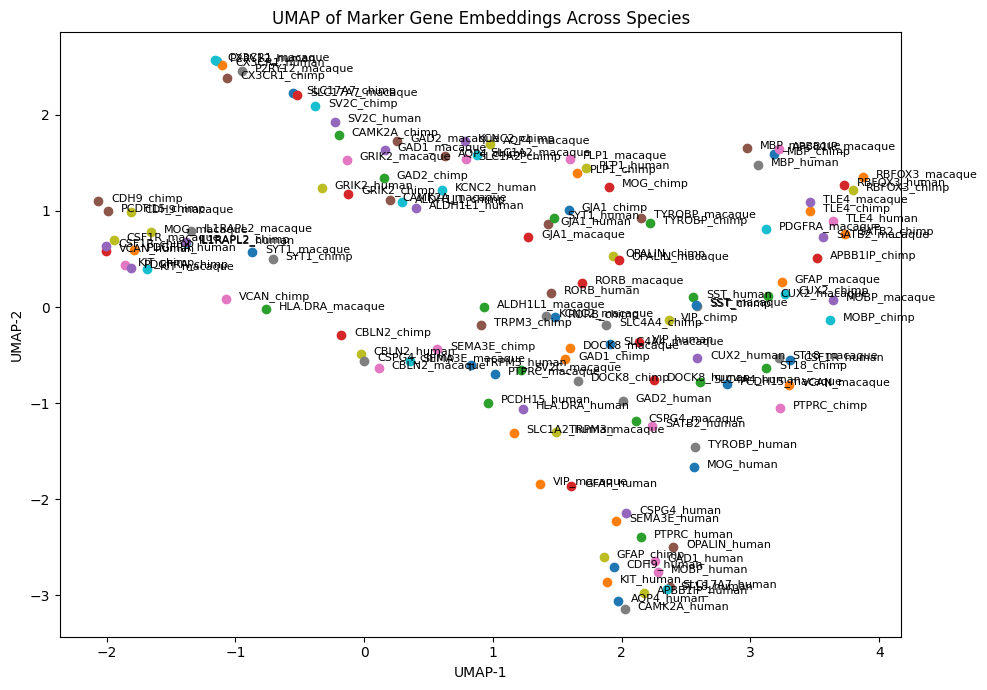

In [73]:
# === 5. Optional: UMAP Visualization for all embeddings ===
combined_embeddings = []
combined_labels = []
for sp, emb_dict in all_embeddings.items():
    for gene, emb in emb_dict.items():
        combined_embeddings.append(emb)
        combined_labels.append(f"{gene}_{sp}")

reducer = umap.UMAP()
embedding_2d = reducer.fit_transform(np.stack(combined_embeddings))

plt.figure(figsize=(10, 7))
for label, (x, y) in zip(combined_labels, embedding_2d):
    plt.scatter(x, y)
    plt.text(x+0.1, y, label, fontsize=8)
plt.title("UMAP of Marker Gene Embeddings Across Species")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()


In [4]:
!git config --global user.email "dennis00@ucsb.edu"
!git config --global user.name "Dennis"


In [ ]:
!mv /content/ESM1b_prediction.ipynb.ipynb /content/y/

In [10]:
!pwd

/content


In [6]:
import os

In [9]:
os.getcwd()

'/content'